# Library

In [1]:
import os
import logging
import json

import pandas as pd
import numpy as np

from PIL import Image, ImageDraw

from datasets import load_dataset, Dataset

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from transformers import AutoImageProcessor, AutoProcessor, AutoModelForZeroShotObjectDetection, TrainingArguments, pipeline

import torch
import albumentations

from HungarianMatcher import HungarianMatcher
from SetCriterion import SetCriterion
from CustomTrainer import CustomTrainer

In [2]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Logging

In [3]:
# Configure logging (example for `logging` module)
# logging.basicConfig(
#     level=logging.WARNING,  # Adjust as needed (DEBUG, INFO, WARNING, ERROR, CRITICAL)
#     format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
# )

# Data

In [4]:
df = pd.read_json('../data/vlm.jsonl', lines=True)

lst = list(filter(lambda x: x != None, pd.DataFrame([i for i in list(df['annotations'].apply(lambda x: [i['caption'] for i in x]))]).to_numpy().flatten()))
categories = list(dict.fromkeys(lst))

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

text_inputs = list(id2label.values())
pd.DataFrame(text_inputs)

,0
0,grey missile
1,"red, white, and blue light aircraft"
2,green and black missile
3,white and red helicopter
4,grey camouflage fighter jet
...,...
121,black and white cargo aircraft
122,white helicopter
123,black and yellow drone
124,yellow missile


In [5]:
# obj_lst = pd.read_json('categories.jsonl', lines=True)
# categories = np.unique(obj_lst.to_numpy())

# id2label = {index: x for index, x in enumerate(categories, start=0)}
# label2id = {v: k for k, v in id2label.items()}

# text_inputs = list(id2label.values())
# # pd.DataFrame({'categories':text_inputs}).to_json('../data/categories.jsonl', orient='records', lines=True)
# pd.DataFrame({'categories':text_inputs})

In [6]:
vlm_imgs = load_dataset('ekmi00/vlm-images')
temp = list(map(lambda x: json.loads(str(x).replace("'", '"')), vlm_imgs['train']['objects']))
vlm_imgs['train'] = vlm_imgs['train'].remove_columns('objects')
vlm_imgs['train'] = vlm_imgs['train'].add_column('objects', column=temp)
vlm_imgs['train'] = vlm_imgs['train'].select(range(100))
vlm_imgs['train']

Resolving data files:   0%|          | 0/3001 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_rows: 100
})

In [7]:
vlm_imgs = vlm_imgs['train'].train_test_split(test_size=0.2, shuffle=False)
vlm_imgs

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 80
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 20
    })
})

# Model & Processor

In [8]:
# using image processor from detr
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

checkpoint = "google/owlvit-base-patch32"
processor = AutoProcessor.from_pretrained(checkpoint)

model = AutoModelForZeroShotObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
model.to(device)

print("loaded!")

# other better checkpoints, but would run out of memory with current T4 instance for fine-tuning, could be use for inference
# google/owlvit-base-patch32
# google/owlv2-base-patch16
# google/owlv2-large-patch14-finetuned
# google/owlv2-base-patch16-ensemble
# while with significant better performance, would run into OOM (Out of memory)

loaded!


[{'score': 0.0276934877038002, 'label': 'yellow plane', 'box': {'xmin': 571, 'ymin': 146, 'xmax': 619, 'ymax': 196}}]


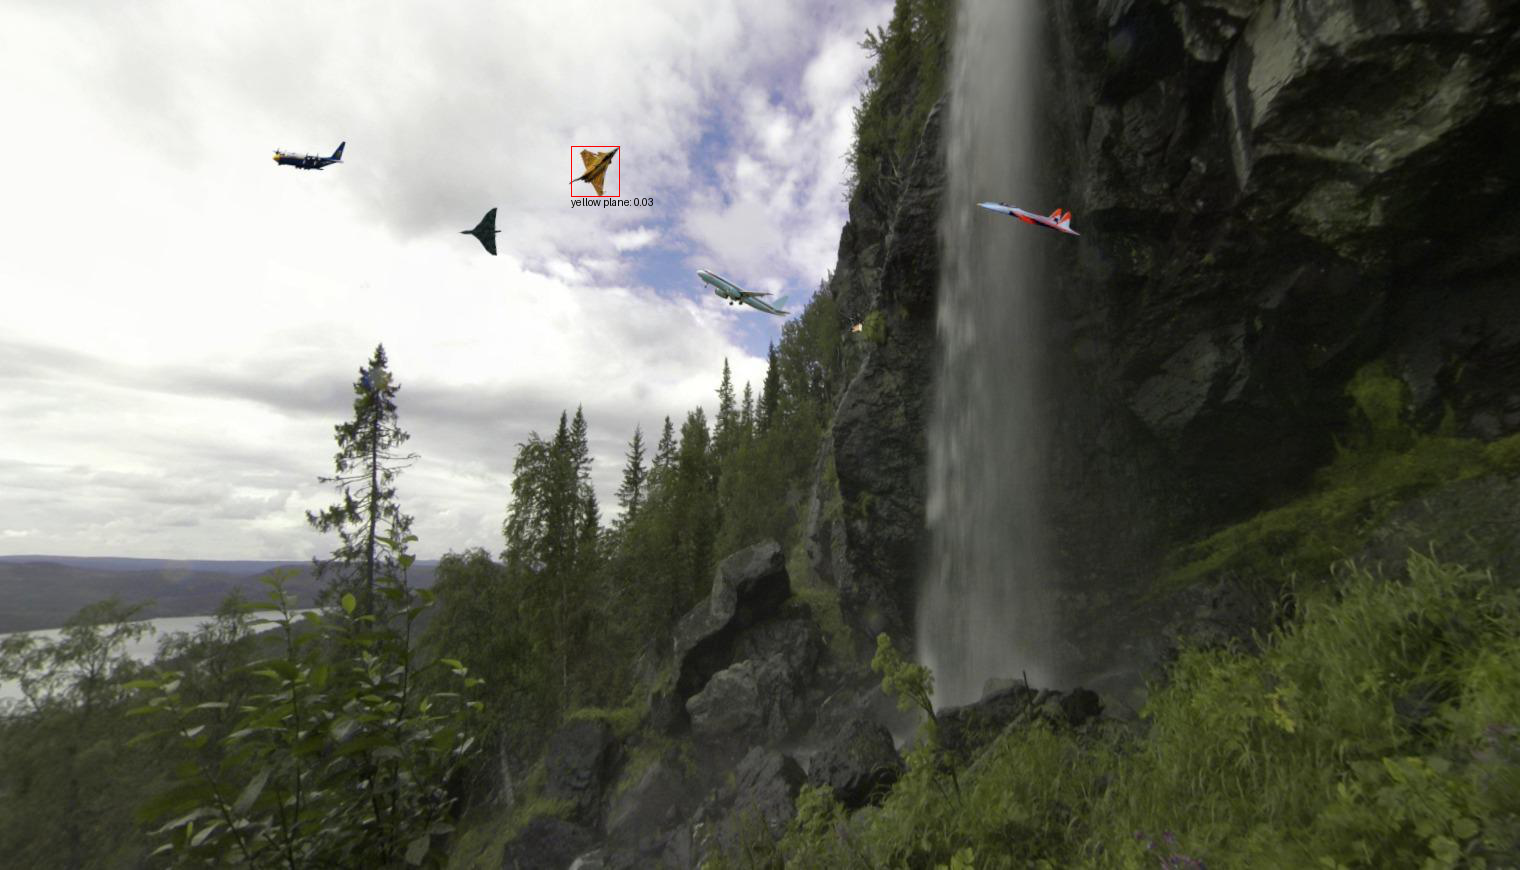

In [9]:
detector = pipeline(model=checkpoint, task="zero-shot-object-detection") #checkpoint
image = vlm_imgs["train"][5]["image"]

predictions = detector(
    image,
    candidate_labels=['yellow plane'], 
    threshold=1e-2,	
    top_k=5
)
print(predictions)

draw = ImageDraw.Draw(image)

if bool(predictions):
	prediction = max(predictions, key=lambda x: x['score'])
	box = prediction["box"]
	label = prediction["label"]
	score = prediction["score"]

	xmin, ymin, xmax, ymax = box.values()
	draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
	draw.text((xmin, ymax), f"{label}: {round(score,2)}", fill="black")

# for prediction in predictions:
# 	box = prediction["box"]
# 	label = prediction["label"]
# 	score = prediction["score"]

# 	xmin, ymin, xmax, ymax = box.values()
# 	draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
# 	draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="black")

image

# Encoding

In [10]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)


def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    transformed_data = []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])
        transformed_data.append(processor(text=text_inputs, images=image, return_tensors="pt"))

    
    return {"transformed_data":transformed_data}

# transforming a batch
def transform_aug_ann_labels(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

def collate_fn(batch):
    input_ids = torch.Tensor([item["input_ids"] for item in batch]).int()
    input_ids = input_ids.to(device)
    attention_mask = torch.Tensor([item["attention_mask"] for item in batch]).int()
    attention_mask = attention_mask.to(device)
    pixel_values = torch.Tensor([item["pixel_values"] for item in batch])
    pixel_values = pixel_values.to(device)
    labels = []
    for item in batch:
        for (key, value) in item["labels"].items():
            item["labels"][key] = torch.Tensor(value).to(device)
        labels.append(item["labels"])
     
    batch = {}
    batch["input_ids"] = input_ids
    batch["attention_mask"] = attention_mask
    batch["pixel_values"] = pixel_values
    batch["labels"] = labels
    return batch

In [11]:
#applying to the datasets
transform_1 = vlm_imgs["train"].with_transform(transform_aug_ann)
transform_2 = vlm_imgs["train"].with_transform(transform_aug_ann_labels)

#applying to the datasets
transform_1_test = vlm_imgs["test"].with_transform(transform_aug_ann)
transform_2_test = vlm_imgs["test"].with_transform(transform_aug_ann_labels)

def dataset_prep(transform_1, transform_2):
    data = []
    for i in range(len(transform_1)):
        dict_ = {}
        dict_["input_ids"] = transform_1[i]["transformed_data"]["input_ids"]
        dict_["attention_mask"] = transform_1[i]["transformed_data"]["attention_mask"]
        dict_["pixel_values"] = transform_1[i]["transformed_data"]["pixel_values"][0]
        dict_["labels"] = transform_2[i]["labels"]
        data.append(dict_)

    # Preprocessed Training Data
    x_dataset = Dataset.from_list(data)
    return x_dataset


train_dataset = dataset_prep(transform_1, transform_2)
train_dataset.features

test_dataset = dataset_prep(transform_1_test, transform_2_test)
test_dataset.features

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None),
 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'labels': {'area': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
  'boxes': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None),
  'class_labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'image_id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'iscrowd': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'orig_size': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'size': Sequence(feature=Value(dtype='int

# Training

In [15]:
training_args = TrainingArguments(
    output_dir="owlvit-FT",
    per_device_train_batch_size=1,
    num_train_epochs=5,
    # fp16=False,
    save_steps=100,
    logging_steps=5,	
    learning_rate=1e-5, #1e-5
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    gradient_accumulation_steps=1,
    push_to_hub=False,
    report_to='none', # disable wandb
)


# use new trainer
trainer = CustomTrainer(
	model=model,
	args=training_args,
	data_collator=collate_fn,
	train_dataset=train_dataset,
	tokenizer=processor, 
	categories=categories
)
 
eval_dict = trainer.train()

  0%|          | 0/400 [00:00<?, ?it/s]

INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 83.,  40., 100.,  74.,  14.,  48., 107.], device='cuda:0')
INFO:root:forward - tensor([ 83,  40, 100,  74,  14,  48, 107], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([105.,  64., 122.,  57.,  44.,  68.,  18.], device='cuda:0')
INFO:root:forward - tensor([105,  64, 122,  57,  44,  68,  18], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([87., 98., 73.], device='cuda:0')
INFO:root:forward - tensor([87, 98, 73], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_

{'loss': 577.0525, 'grad_norm': 8.170554161071777, 'learning_rate': 9.875000000000002e-05, 'epoch': 0.06}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 37., 100., 107.,  74.], device='cuda:0')
INFO:root:forward - tensor([ 37, 100, 107,  74], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49., 63., 85., 13., 44., 31., 67.], device='cuda:0')
INFO:root:forward - tensor([49, 63, 85, 13, 44, 31, 67], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([109.,  26.,  13.,  61.,  22.], device='cuda:0')
INFO:root:forward - tensor([109,  26,  13,  61,  22], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pr

{'loss': 175.6048, 'grad_norm': 20.397815704345703, 'learning_rate': 9.75e-05, 'epoch': 0.12}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 44.,  38.,  22., 107.,  76.,  32.,  17., 108.], device='cuda:0')
INFO:root:forward - tensor([ 44,  38,  22, 107,  76,  32,  17, 108], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 28.,  33.,  55.,  84., 101.,  48.,  52.,  73.], device='cuda:0')
INFO:root:forward - tensor([ 28,  33,  55,  84, 101,  48,  52,  73], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([29., 39., 73.], device='cuda:0')
INFO:root:forward - tensor([29, 39, 73], device='cuda:0', dtype=torch.i

{'loss': 236.3725, 'grad_norm': 51.16017150878906, 'learning_rate': 9.625000000000001e-05, 'epoch': 0.19}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 74., 108.,  14.,  56., 102.,  15.], device='cuda:0')
INFO:root:forward - tensor([ 74, 108,  14,  56, 102,  15], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([26., 73.,  6., 87., 49.,  2.], device='cuda:0')
INFO:root:forward - tensor([26, 73,  6, 87, 49,  2], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([46., 31., 21., 14.], device='cuda:0')
INFO:root:forward - tensor([46, 31, 21, 14], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_box

{'loss': 121.1093, 'grad_norm': 17.819013595581055, 'learning_rate': 9.5e-05, 'epoch': 0.25}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([92., 60., 20., 41.], device='cuda:0')
INFO:root:forward - tensor([92, 60, 20, 41], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 82.,  36., 107.,  91.,  48.,  46.], device='cuda:0')
INFO:root:forward - tensor([ 82,  36, 107,  91,  48,  46], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([19., 70., 25., 18.], device='cuda:0')
INFO:root:forward - tensor([19, 70, 25, 18], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds'

{'loss': 5.9058, 'grad_norm': 9.79061222076416, 'learning_rate': 9.375e-05, 'epoch': 0.31}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 49., 107.,  73.,  74.,  14.,  45.], device='cuda:0')
INFO:root:forward - tensor([ 49, 107,  73,  74,  14,  45], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 26., 107.,  89.,  28., 100.,  99.,  36.,  89.], device='cuda:0')
INFO:root:forward - tensor([ 26, 107,  89,  28, 100,  99,  36,  89], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 74.,  45.,  45.,  36., 120.,  31.,  38.,  91.], device='cuda:0')
INFO:root:forward - tensor([ 74,  45,  45,  36, 120,  31,  38,  91]

{'loss': 8.7934, 'grad_norm': 9.848434448242188, 'learning_rate': 9.250000000000001e-05, 'epoch': 0.38}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([105.,  66.,  21.,  17., 107.,  16.,   1.,  40.], device='cuda:0')
INFO:root:forward - tensor([105,  66,  21,  17, 107,  16,   1,  40], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([32., 13., 25.,  2., 57.,  5., 28., 70.], device='cuda:0')
INFO:root:forward - tensor([32, 13, 25,  2, 57,  5, 28, 70], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([  2., 113.,  77.,  79.,   9.,  40., 102., 108.], device='cuda:0')
INFO:root:forward - tensor([  2, 113,  77,  79,   9,  40, 102

{'loss': 8.6204, 'grad_norm': 10.294306755065918, 'learning_rate': 9.125e-05, 'epoch': 0.44}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([19., 44.,  8., 83., 14., 63., 80., 17.], device='cuda:0')
INFO:root:forward - tensor([19, 44,  8, 83, 14, 63, 80, 17], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([91., 51., 85., 32., 21.], device='cuda:0')
INFO:root:forward - tensor([91, 51, 85, 32, 21], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([14., 41., 89.], device='cuda:0')
INFO:root:forward - tensor([14, 41, 89], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_e

{'loss': 6.4977, 'grad_norm': 15.965266227722168, 'learning_rate': 9e-05, 'epoch': 0.5}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([120.,  25.,  71.,  25.,  38.,  13.], device='cuda:0')
INFO:root:forward - tensor([120,  25,  71,  25,  38,  13], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 2., 13., 62., 51.], device='cuda:0')
INFO:root:forward - tensor([ 2, 13, 62, 51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([37.,  3., 28., 83., 13., 66.], device='cuda:0')
INFO:root:forward - tensor([37,  3, 28, 83, 13, 66], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_box

{'loss': 6.884, 'grad_norm': 16.212196350097656, 'learning_rate': 8.875e-05, 'epoch': 0.56}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([107.,  84.,  56.,  98.,   8.,  82., 101.], device='cuda:0')
INFO:root:forward - tensor([107,  84,  56,  98,   8,  82, 101], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 32.,  33.,  25., 107.,  53.], device='cuda:0')
INFO:root:forward - tensor([ 32,  33,  25, 107,  53], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([13., 13., 40., 25.], device='cuda:0')
INFO:root:forward - tensor([13, 13, 40, 25], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits

{'loss': 7.488, 'grad_norm': 4.8494391441345215, 'learning_rate': 8.75e-05, 'epoch': 0.62}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([12., 82., 68., 71.], device='cuda:0')
INFO:root:forward - tensor([12, 82, 68, 71], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 47.,  25.,  55.,  19.,  44., 101.,   6.,  65.], device='cuda:0')
INFO:root:forward - tensor([ 47,  25,  55,  19,  44, 101,   6,  65], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([85., 77., 57., 89., 31., 85., 63.], device='cuda:0')
INFO:root:forward - tensor([85, 77, 57, 89, 31, 85, 63], device='cuda:0', dtype=torch.int32)
INFO:root:outputs

{'loss': 8.0969, 'grad_norm': 4.733053207397461, 'learning_rate': 8.625000000000001e-05, 'epoch': 0.69}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49.,  0.,  4.], device='cuda:0')
INFO:root:forward - tensor([49,  0,  4], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 0., 38., 51., 90., 51., 35.], device='cuda:0')
INFO:root:forward - tensor([ 0, 38, 51, 90, 51, 35], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 16.,  64., 106.,   0.,  84.,  14.,  32.], device='cuda:0')
INFO:root:forward - tensor([ 16,  64, 106,   0,  84,  14,  32], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_b

{'loss': 6.8819, 'grad_norm': 17.79862403869629, 'learning_rate': 8.5e-05, 'epoch': 0.75}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([25., 17.,  1., 39., 35., 21.], device='cuda:0')
INFO:root:forward - tensor([25, 17,  1, 39, 35, 21], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 15., 102.,  33.,  84.,  26.,  73.,  65.,   1.], device='cuda:0')
INFO:root:forward - tensor([ 15, 102,  33,  84,  26,  73,  65,   1], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([68., 29.,  5., 22., 65.], device='cuda:0')
INFO:root:forward - tensor([68, 29,  5, 22, 65], device='cuda:0', dtype=torch.int32)
INFO:root:outputs

{'loss': 7.126, 'grad_norm': 21.645322799682617, 'learning_rate': 8.375e-05, 'epoch': 0.81}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 62.,  13.,  73., 106.,  33., 108.,  53.,  36.], device='cuda:0')
INFO:root:forward - tensor([ 62,  13,  73, 106,  33, 108,  53,  36], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 49., 100.,  37.], device='cuda:0')
INFO:root:forward - tensor([ 49, 100,  37], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([102.,   2.,  74.,   5.,  51.], device='cuda:0')
INFO:root:forward - tensor([102,   2,  74,   5,  51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dic

{'loss': 6.2126, 'grad_norm': 7.185533046722412, 'learning_rate': 8.25e-05, 'epoch': 0.88}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 37., 101.,  73.,  27.,  93.,   7.], device='cuda:0')
INFO:root:forward - tensor([ 37, 101,  73,  27,  93,   7], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 82.,  83., 120.,  63.,  40.,  76.,  22.], device='cuda:0')
INFO:root:forward - tensor([ 82,  83, 120,  63,  40,  76,  22], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([22.,  9.,  8.], device='cuda:0')
INFO:root:forward - tensor([22,  9,  8], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logi

{'loss': 6.4194, 'grad_norm': 3.544158935546875, 'learning_rate': 8.125000000000001e-05, 'epoch': 0.94}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([80., 65., 40., 76., 85.], device='cuda:0')
INFO:root:forward - tensor([80, 65, 40, 76, 85], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 70.,  30.,  67.,  61.,  71.,  87., 122.,  45.], device='cuda:0')
INFO:root:forward - tensor([ 70,  30,  67,  61,  71,  87, 122,  45], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([31., 39., 63., 43., 33.], device='cuda:0')
INFO:root:forward - tensor([31, 39, 63, 43, 33], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=d

{'loss': 7.4878, 'grad_norm': 16.267620086669922, 'learning_rate': 8e-05, 'epoch': 1.0}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 70.,  30.,  67.,  61.,  71.,  87., 122.,  45.], device='cuda:0')
INFO:root:forward - tensor([ 70,  30,  67,  61,  71,  87, 122,  45], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([  4.,  85.,  24.,  99.,  18., 113.], device='cuda:0')
INFO:root:forward - tensor([  4,  85,  24,  99,  18, 113], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([91., 51., 85., 32., 21.], device='cuda:0')
INFO:root:forward - tensor([91, 51, 85, 32, 21], device='cuda:0', dtype=torch.int32)
INFO:

{'loss': 8.1647, 'grad_norm': 21.014984130859375, 'learning_rate': 7.875e-05, 'epoch': 1.06}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 37., 100., 107.,  74.], device='cuda:0')
INFO:root:forward - tensor([ 37, 100, 107,  74], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49.,  0.,  4.], device='cuda:0')
INFO:root:forward - tensor([49,  0,  4], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 0., 38., 51., 90., 51., 35.], device='cuda:0')
INFO:root:forward - tensor([ 0, 38, 51, 90, 51, 35], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embe

{'loss': 6.0226, 'grad_norm': 8.544413566589355, 'learning_rate': 7.75e-05, 'epoch': 1.12}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 82.,  83., 120.,  63.,  40.,  76.,  22.], device='cuda:0')
INFO:root:forward - tensor([ 82,  83, 120,  63,  40,  76,  22], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([107.,  84.,  56.,  98.,   8.,  82., 101.], device='cuda:0')
INFO:root:forward - tensor([107,  84,  56,  98,   8,  82, 101], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 83.,  40., 100.,  74.,  14.,  48., 107.], device='cuda:0')
INFO:root:forward - tensor([ 83,  40, 100,  74,  14,  48, 107], device='cuda:0',

{'loss': 7.7214, 'grad_norm': 2.808800220489502, 'learning_rate': 7.625e-05, 'epoch': 1.19}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([99., 80., 79., 31.], device='cuda:0')
INFO:root:forward - tensor([99, 80, 79, 31], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([26., 73.,  6., 87., 49.,  2.], device='cuda:0')
INFO:root:forward - tensor([26, 73,  6, 87, 49,  2], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([  3.,  44.,   9., 105.], device='cuda:0')
INFO:root:forward - tensor([  3,  44,   9, 105], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'i

{'loss': 5.458, 'grad_norm': 32.313194274902344, 'learning_rate': 7.500000000000001e-05, 'epoch': 1.25}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([52., 31., 92., 48., 29.], device='cuda:0')
INFO:root:forward - tensor([52, 31, 92, 48, 29], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([47., 53., 32., 46., 16., 61., 13.,  9.], device='cuda:0')
INFO:root:forward - tensor([47, 53, 32, 46, 16, 61, 13,  9], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([63., 89., 44., 79., 21., 48.], device='cuda:0')
INFO:root:forward - tensor([63, 89, 44, 79, 21, 48], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['log

{'loss': 7.2773, 'grad_norm': 10.763017654418945, 'learning_rate': 7.375e-05, 'epoch': 1.31}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([13., 37., 55.], device='cuda:0')
INFO:root:forward - tensor([13, 37, 55], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([85., 77., 57., 89., 31., 85., 63.], device='cuda:0')
INFO:root:forward - tensor([85, 77, 57, 89, 31, 85, 63], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49., 85., 33., 51.], device='cuda:0')
INFO:root:forward - tensor([49, 85, 33, 51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_emb

{'loss': 5.7465, 'grad_norm': 18.62053108215332, 'learning_rate': 7.25e-05, 'epoch': 1.38}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([90., 98., 37., 49., 48.], device='cuda:0')
INFO:root:forward - tensor([90, 98, 37, 49, 48], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([105.,  66.,  21.,  17., 107.,  16.,   1.,  40.], device='cuda:0')
INFO:root:forward - tensor([105,  66,  21,  17, 107,  16,   1,  40], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 2., 13., 62., 51.], device='cuda:0')
INFO:root:forward - tensor([ 2, 13, 62, 51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(

{'loss': 6.714, 'grad_norm': 13.320343017578125, 'learning_rate': 7.125000000000001e-05, 'epoch': 1.44}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([13., 13., 40., 25.], device='cuda:0')
INFO:root:forward - tensor([13, 13, 40, 25], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([105.,  64., 122.,  57.,  44.,  68.,  18.], device='cuda:0')
INFO:root:forward - tensor([105,  64, 122,  57,  44,  68,  18], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 74.,  22.,  14.,   5.,   2., 102.], device='cuda:0')
INFO:root:forward - tensor([ 74,  22,  14,   5,   2, 102], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_ke

{'loss': 7.5376, 'grad_norm': 15.71245288848877, 'learning_rate': 7e-05, 'epoch': 1.5}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49., 45., 61.], device='cuda:0')
INFO:root:forward - tensor([49, 45, 61], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([14., 41., 89.], device='cuda:0')
INFO:root:forward - tensor([14, 41, 89], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 28.,  33.,  55.,  84., 101.,  48.,  52.,  73.], device='cuda:0')
INFO:root:forward - tensor([ 28,  33,  55,  84, 101,  48,  52,  73], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 't

{'loss': 6.8749, 'grad_norm': 19.88898468017578, 'learning_rate': 6.875e-05, 'epoch': 1.56}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([71.,  1., 87.], device='cuda:0')
INFO:root:forward - tensor([71,  1, 87], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([29., 39., 73.], device='cuda:0')
INFO:root:forward - tensor([29, 39, 73], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([120.,  25.,  71.,  25.,  38.,  13.], device='cuda:0')
INFO:root:forward - tensor([120,  25,  71,  25,  38,  13], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 

{'loss': 6.8504, 'grad_norm': 5.571401119232178, 'learning_rate': 6.750000000000001e-05, 'epoch': 1.62}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 40.,   1., 101.,  49.,   7.], device='cuda:0')
INFO:root:forward - tensor([ 40,   1, 101,  49,   7], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([113.,  63.,  16.,  26.,  73.,  40.], device='cuda:0')
INFO:root:forward - tensor([113,  63,  16,  26,  73,  40], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([19., 44.,  8., 83., 14., 63., 80., 17.], device='cuda:0')
INFO:root:forward - tensor([19, 44,  8, 83, 14, 63, 80, 17], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.

{'loss': 8.2482, 'grad_norm': 7.439621925354004, 'learning_rate': 6.625e-05, 'epoch': 1.69}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([22.,  9.,  8.], device='cuda:0')
INFO:root:forward - tensor([22,  9,  8], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([68., 29.,  5., 22., 65.], device='cuda:0')
INFO:root:forward - tensor([68, 29,  5, 22, 65], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 21., 113.,  55.,  51.], device='cuda:0')
INFO:root:forward - tensor([ 21, 113,  55,  51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'cla

{'loss': 6.4041, 'grad_norm': 8.927634239196777, 'learning_rate': 6.500000000000001e-05, 'epoch': 1.75}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 32.,  33.,  25., 107.,  53.], device='cuda:0')
INFO:root:forward - tensor([ 32,  33,  25, 107,  53], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([25., 99., 52.,  4., 25.], device='cuda:0')
INFO:root:forward - tensor([25, 99, 52,  4, 25], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 66., 105.,  63.,  15.,  25.,  29.,  11.,  39.], device='cuda:0')
INFO:root:forward - tensor([ 66, 105,  63,  15,  25,  29,  11,  39], device='cuda:0',
       dtype=torch.int32)
INFO:root:output

{'loss': 6.6168, 'grad_norm': 6.549360275268555, 'learning_rate': 6.375e-05, 'epoch': 1.81}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([61., 51., 19., 18., 52., 98., 49.], device='cuda:0')
INFO:root:forward - tensor([61, 51, 19, 18, 52, 98, 49], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 44.,  38.,  22., 107.,  76.,  32.,  17., 108.], device='cuda:0')
INFO:root:forward - tensor([ 44,  38,  22, 107,  76,  32,  17, 108], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49., 63., 85., 13., 44., 31., 67.], device='cuda:0')
INFO:root:forward - tensor([49, 63, 85, 13, 44, 31, 67], device='cuda:0', dtype=tor

{'loss': 7.9485, 'grad_norm': 22.512025833129883, 'learning_rate': 6.25e-05, 'epoch': 1.88}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 74.,  45.,  45.,  36., 120.,  31.,  38.,  91.], device='cuda:0')
INFO:root:forward - tensor([ 74,  45,  45,  36, 120,  31,  38,  91], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 47.,  25.,  55.,  19.,  44., 101.,   6.,  65.], device='cuda:0')
INFO:root:forward - tensor([ 47,  25,  55,  19,  44, 101,   6,  65], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([106.,  13.,  25.,  11., 109.,  56.,  18.], device='cuda:0')
INFO:root:forward - tensor([106,  13,  25,  

{'loss': 7.7713, 'grad_norm': 4.86911678314209, 'learning_rate': 6.125000000000001e-05, 'epoch': 1.94}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([25., 17.,  1., 39., 35., 21.], device='cuda:0')
INFO:root:forward - tensor([25, 17,  1, 39, 35, 21], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 44., 106.,  18.,  85.,  79.], device='cuda:0')
INFO:root:forward - tensor([ 44, 106,  18,  85,  79], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 82.,  36., 107.,  91.,  48.,  46.], device='cuda:0')
INFO:root:forward - tensor([ 82,  36, 107,  91,  48,  46], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys([

{'loss': 6.5761, 'grad_norm': 27.513385772705078, 'learning_rate': 6e-05, 'epoch': 2.0}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([27., 15., 98.], device='cuda:0')
INFO:root:forward - tensor([27, 15, 98], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 44., 106.,  18.,  85.,  79.], device='cuda:0')
INFO:root:forward - tensor([ 44, 106,  18,  85,  79], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 22., 105.,  45., 122.,  33.,  87., 106.], device='cuda:0')
INFO:root:forward - tensor([ 22, 105,  45, 122,  33,  87, 106], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_

{'loss': 6.5921, 'grad_norm': 14.126635551452637, 'learning_rate': 5.8750000000000005e-05, 'epoch': 2.06}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([52., 31., 92., 48., 29.], device='cuda:0')
INFO:root:forward - tensor([52, 31, 92, 48, 29], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([70.,  0., 45.], device='cuda:0')
INFO:root:forward - tensor([70,  0, 45], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 26., 107.,  89.,  28., 100.,  99.,  36.,  89.], device='cuda:0')
INFO:root:forward - tensor([ 26, 107,  89,  28, 100,  99,  36,  89], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits'

{'loss': 6.5872, 'grad_norm': 27.754915237426758, 'learning_rate': 5.7499999999999995e-05, 'epoch': 2.12}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([13.,  2.,  8.], device='cuda:0')
INFO:root:forward - tensor([13,  2,  8], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 49., 100.,  37.], device='cuda:0')
INFO:root:forward - tensor([ 49, 100,  37], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([47., 53., 32., 46., 16., 61., 13.,  9.], device='cuda:0')
INFO:root:forward - tensor([47, 53, 32, 46, 16, 61, 13,  9], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'ima

{'loss': 7.5228, 'grad_norm': 7.836639404296875, 'learning_rate': 5.6250000000000005e-05, 'epoch': 2.19}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([63., 89., 44., 79., 21., 48.], device='cuda:0')
INFO:root:forward - tensor([63, 89, 44, 79, 21, 48], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([14., 41., 89.], device='cuda:0')
INFO:root:forward - tensor([14, 41, 89], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 92.,  31.,  30., 107.,  76.], device='cuda:0')
INFO:root:forward - tensor([ 92,  31,  30, 107,  76], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 

{'loss': 6.6353, 'grad_norm': 19.323688507080078, 'learning_rate': 5.500000000000001e-05, 'epoch': 2.25}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49., 45., 61.], device='cuda:0')
INFO:root:forward - tensor([49, 45, 61], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([17., 13., 30., 51., 82.], device='cuda:0')
INFO:root:forward - tensor([17, 13, 30, 51, 82], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([120.,  25.,  71.,  25.,  38.,  13.], device='cuda:0')
INFO:root:forward - tensor([120,  25,  71,  25,  38,  13], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds'

{'loss': 7.0663, 'grad_norm': 3.823416233062744, 'learning_rate': 5.375e-05, 'epoch': 2.31}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([105.,  66.,  21.,  17., 107.,  16.,   1.,  40.], device='cuda:0')
INFO:root:forward - tensor([105,  66,  21,  17, 107,  16,   1,  40], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([92., 60., 20., 41.], device='cuda:0')
INFO:root:forward - tensor([92, 60, 20, 41], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 36., 101.,   2.,  29.,  25.], device='cuda:0')
INFO:root:forward - tensor([ 36, 101,   2,  29,  25], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=

{'loss': 7.9613, 'grad_norm': 15.16030216217041, 'learning_rate': 5.25e-05, 'epoch': 2.38}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 0., 38., 51., 90., 51., 35.], device='cuda:0')
INFO:root:forward - tensor([ 0, 38, 51, 90, 51, 35], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([29., 39., 73.], device='cuda:0')
INFO:root:forward - tensor([29, 39, 73], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([106.,  13.,  25.,  11., 109.,  56.,  18.], device='cuda:0')
INFO:root:forward - tensor([106,  13,  25,  11, 109,  56,  18], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_b

{'loss': 6.7707, 'grad_norm': 33.08441162109375, 'learning_rate': 5.125e-05, 'epoch': 2.44}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([91., 51., 85., 32., 21.], device='cuda:0')
INFO:root:forward - tensor([91, 51, 85, 32, 21], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([85., 77., 57., 89., 31., 85., 63.], device='cuda:0')
INFO:root:forward - tensor([85, 77, 57, 89, 31, 85, 63], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([31., 39., 63., 43., 33.], device='cuda:0')
INFO:root:forward - tensor([31, 39, 63, 43, 33], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes'

{'loss': 7.7116, 'grad_norm': 18.757465362548828, 'learning_rate': 5e-05, 'epoch': 2.5}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 37., 100., 107.,  74.], device='cuda:0')
INFO:root:forward - tensor([ 37, 100, 107,  74], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([113.,  63.,  16.,  26.,  73.,  40.], device='cuda:0')
INFO:root:forward - tensor([113,  63,  16,  26,  73,  40], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([  3.,  44.,   9., 105.], device='cuda:0')
INFO:root:forward - tensor([  3,  44,   9, 105], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes

{'loss': 7.0659, 'grad_norm': 10.512717247009277, 'learning_rate': 4.875e-05, 'epoch': 2.56}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49.,  0.,  4.], device='cuda:0')
INFO:root:forward - tensor([49,  0,  4], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([71.,  1., 87.], device='cuda:0')
INFO:root:forward - tensor([71,  1, 87], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 32.,  33.,  25., 107.,  53.], device='cuda:0')
INFO:root:forward - tensor([ 32,  33,  25, 107,  53], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embe

{'loss': 5.7227, 'grad_norm': 5.693095684051514, 'learning_rate': 4.75e-05, 'epoch': 2.62}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 7.,  9.,  4., 57., 65.], device='cuda:0')
INFO:root:forward - tensor([ 7,  9,  4, 57, 65], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([22.,  9.,  8.], device='cuda:0')
INFO:root:forward - tensor([22,  9,  8], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([  2., 113.,  77.,  79.,   9.,  40., 102., 108.], device='cuda:0')
INFO:root:forward - tensor([  2, 113,  77,  79,   9,  40, 102, 108], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits'

{'loss': 7.0244, 'grad_norm': 23.520977020263672, 'learning_rate': 4.6250000000000006e-05, 'epoch': 2.69}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([102.,   1.,  91.], device='cuda:0')
INFO:root:forward - tensor([102,   1,  91], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([13., 37., 55.], device='cuda:0')
INFO:root:forward - tensor([13, 37, 55], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([26., 73.,  6., 87., 49.,  2.], device='cuda:0')
INFO:root:forward - tensor([26, 73,  6, 87, 49,  2], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class

{'loss': 6.8147, 'grad_norm': 19.397052764892578, 'learning_rate': 4.5e-05, 'epoch': 2.75}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([19., 70., 25., 18.], device='cuda:0')
INFO:root:forward - tensor([19, 70, 25, 18], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([12., 82., 68., 71.], device='cuda:0')
INFO:root:forward - tensor([12, 82, 68, 71], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 82.,  36., 107.,  91.,  48.,  46.], device='cuda:0')
INFO:root:forward - tensor([ 82,  36, 107,  91,  48,  46], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds'

{'loss': 6.8447, 'grad_norm': 24.45475196838379, 'learning_rate': 4.375e-05, 'epoch': 2.81}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49., 63., 85., 13., 44., 31., 67.], device='cuda:0')
INFO:root:forward - tensor([49, 63, 85, 13, 44, 31, 67], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 21., 113.,  55.,  51.], device='cuda:0')
INFO:root:forward - tensor([ 21, 113,  55,  51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 2., 13., 62., 51.], device='cuda:0')
INFO:root:forward - tensor([ 2, 13, 62, 51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_em

{'loss': 6.1787, 'grad_norm': 19.709800720214844, 'learning_rate': 4.25e-05, 'epoch': 2.88}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 15., 102.,  33.,  84.,  26.,  73.,  65.,   1.], device='cuda:0')
INFO:root:forward - tensor([ 15, 102,  33,  84,  26,  73,  65,   1], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([  4.,  85.,  24.,  99.,  18., 113.], device='cuda:0')
INFO:root:forward - tensor([  4,  85,  24,  99,  18, 113], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([37.,  3., 28., 83., 13., 66.], device='cuda:0')
INFO:root:forward - tensor([37,  3, 28, 83, 13, 66], device='cuda:0', dtype=torch.int

{'loss': 8.138, 'grad_norm': 38.260372161865234, 'learning_rate': 4.125e-05, 'epoch': 2.94}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([13., 13., 40., 25.], device='cuda:0')
INFO:root:forward - tensor([13, 13, 40, 25], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([80., 65., 40., 76., 85.], device='cuda:0')
INFO:root:forward - tensor([80, 65, 40, 76, 85], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([25., 17.,  1., 39., 35., 21.], device='cuda:0')
INFO:root:forward - tensor([25, 17,  1, 39, 35, 21], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', '

{'loss': 6.838, 'grad_norm': 16.496633529663086, 'learning_rate': 4e-05, 'epoch': 3.0}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([90., 98., 37., 49., 48.], device='cuda:0')
INFO:root:forward - tensor([90, 98, 37, 49, 48], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 37., 100., 107.,  74.], device='cuda:0')
INFO:root:forward - tensor([ 37, 100, 107,  74], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([113.,  63.,  16.,  26.,  73.,  40.], device='cuda:0')
INFO:root:forward - tensor([113,  63,  16,  26,  73,  40], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxe

{'loss': 6.3739, 'grad_norm': 8.514068603515625, 'learning_rate': 3.875e-05, 'epoch': 3.06}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 28.,  33.,  55.,  84., 101.,  48.,  52.,  73.], device='cuda:0')
INFO:root:forward - tensor([ 28,  33,  55,  84, 101,  48,  52,  73], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 92.,  31.,  30., 107.,  76.], device='cuda:0')
INFO:root:forward - tensor([ 92,  31,  30, 107,  76], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([17., 13., 30., 51., 82.], device='cuda:0')
INFO:root:forward - tensor([17, 13, 30, 51, 82], device='cuda:0', dtype=torch.int32)
INFO:root:output

{'loss': 7.2783, 'grad_norm': 6.321573257446289, 'learning_rate': 3.7500000000000003e-05, 'epoch': 3.12}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 74., 108.,  14.,  56., 102.,  15.], device='cuda:0')
INFO:root:forward - tensor([ 74, 108,  14,  56, 102,  15], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 16.,  64., 106.,   0.,  84.,  14.,  32.], device='cuda:0')
INFO:root:forward - tensor([ 16,  64, 106,   0,  84,  14,  32], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([107.,  84.,  56.,  98.,   8.,  82., 101.], device='cuda:0')
INFO:root:forward - tensor([107,  84,  56,  98,   8,  82, 101], device='cuda:0', dtype=torc

{'loss': 7.6726, 'grad_norm': 13.249756813049316, 'learning_rate': 3.625e-05, 'epoch': 3.19}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([19., 70., 25., 18.], device='cuda:0')
INFO:root:forward - tensor([19, 70, 25, 18], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 47.,  25.,  55.,  19.,  44., 101.,   6.,  65.], device='cuda:0')
INFO:root:forward - tensor([ 47,  25,  55,  19,  44, 101,   6,  65], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([13., 37., 55.], device='cuda:0')
INFO:root:forward - tensor([13, 37, 55], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_b

{'loss': 7.669, 'grad_norm': 13.018644332885742, 'learning_rate': 3.5e-05, 'epoch': 3.25}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([29., 39., 73.], device='cuda:0')
INFO:root:forward - tensor([29, 39, 73], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([  4.,  85.,  24.,  99.,  18., 113.], device='cuda:0')
INFO:root:forward - tensor([  4,  85,  24,  99,  18, 113], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([102.,   2.,  74.,   5.,  51.], device='cuda:0')
INFO:root:forward - tensor([102,   2,  74,   5,  51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'te

{'loss': 7.3055, 'grad_norm': 33.40098190307617, 'learning_rate': 3.375000000000001e-05, 'epoch': 3.31}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([105.,  64., 122.,  57.,  44.,  68.,  18.], device='cuda:0')
INFO:root:forward - tensor([105,  64, 122,  57,  44,  68,  18], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([25., 17.,  1., 39., 35., 21.], device='cuda:0')
INFO:root:forward - tensor([25, 17,  1, 39, 35, 21], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([31., 39., 63., 43., 33.], device='cuda:0')
INFO:root:forward - tensor([31, 39, 63, 43, 33], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(

{'loss': 7.263, 'grad_norm': 8.085455894470215, 'learning_rate': 3.2500000000000004e-05, 'epoch': 3.38}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([61., 51., 19., 18., 52., 98., 49.], device='cuda:0')
INFO:root:forward - tensor([61, 51, 19, 18, 52, 98, 49], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([12., 82., 68., 71.], device='cuda:0')
INFO:root:forward - tensor([12, 82, 68, 71], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([13.,  2.,  8.], device='cuda:0')
INFO:root:forward - tensor([13,  2,  8], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_emb

{'loss': 5.7132, 'grad_norm': 40.652469635009766, 'learning_rate': 3.125e-05, 'epoch': 3.44}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49.,  0.,  4.], device='cuda:0')
INFO:root:forward - tensor([49,  0,  4], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([71.,  1., 87.], device='cuda:0')
INFO:root:forward - tensor([71,  1, 87], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([37.,  3., 28., 83., 13., 66.], device='cuda:0')
INFO:root:forward - tensor([37,  3, 28, 83, 13, 66], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embed

{'loss': 6.4292, 'grad_norm': 17.659563064575195, 'learning_rate': 3e-05, 'epoch': 3.5}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([87., 98., 73.], device='cuda:0')
INFO:root:forward - tensor([87, 98, 73], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([19., 44.,  8., 83., 14., 63., 80., 17.], device='cuda:0')
INFO:root:forward - tensor([19, 44,  8, 83, 14, 63, 80, 17], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([56., 14., 19., 40.,  5.], device='cuda:0')
INFO:root:forward - tensor([56, 14, 19, 40,  5], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_e

{'loss': 7.3075, 'grad_norm': 18.016714096069336, 'learning_rate': 2.8749999999999997e-05, 'epoch': 3.56}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 74.,  22.,  14.,   5.,   2., 102.], device='cuda:0')
INFO:root:forward - tensor([ 74,  22,  14,   5,   2, 102], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([25., 99., 52.,  4., 25.], device='cuda:0')
INFO:root:forward - tensor([25, 99, 52,  4, 25], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 70.,  30.,  67.,  61.,  71.,  87., 122.,  45.], device='cuda:0')
INFO:root:forward - tensor([ 70,  30,  67,  61,  71,  87, 122,  45], device='cuda:0',
       dtype=torch.int32)
INFO:

{'loss': 6.8111, 'grad_norm': 19.802465438842773, 'learning_rate': 2.7500000000000004e-05, 'epoch': 3.62}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([91., 51., 85., 32., 21.], device='cuda:0')
INFO:root:forward - tensor([91, 51, 85, 32, 21], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 26., 107.,  89.,  28., 100.,  99.,  36.,  89.], device='cuda:0')
INFO:root:forward - tensor([ 26, 107,  89,  28, 100,  99,  36,  89], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([92., 60., 20., 41.], device='cuda:0')
INFO:root:forward - tensor([92, 60, 20, 41], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(

{'loss': 7.2865, 'grad_norm': 30.748565673828125, 'learning_rate': 2.625e-05, 'epoch': 3.69}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 7.,  9.,  4., 57., 65.], device='cuda:0')
INFO:root:forward - tensor([ 7,  9,  4, 57, 65], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 21., 113.,  55.,  51.], device='cuda:0')
INFO:root:forward - tensor([ 21, 113,  55,  51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([109.,  26.,  13.,  61.,  22.], device='cuda:0')
INFO:root:forward - tensor([109,  26,  13,  61,  22], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_e

{'loss': 7.0583, 'grad_norm': 23.331453323364258, 'learning_rate': 2.5e-05, 'epoch': 3.75}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([26., 73.,  6., 87., 49.,  2.], device='cuda:0')
INFO:root:forward - tensor([26, 73,  6, 87, 49,  2], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 74.,  45.,  45.,  36., 120.,  31.,  38.,  91.], device='cuda:0')
INFO:root:forward - tensor([ 74,  45,  45,  36, 120,  31,  38,  91], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 82.,  83., 120.,  63.,  40.,  76.,  22.], device='cuda:0')
INFO:root:forward - tensor([ 82,  83, 120,  63,  40,  76,  22], device='cuda:0', dtyp

{'loss': 8.1696, 'grad_norm': 17.95340919494629, 'learning_rate': 2.375e-05, 'epoch': 3.81}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([46., 31., 21., 14.], device='cuda:0')
INFO:root:forward - tensor([46, 31, 21, 14], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 2., 13., 62., 51.], device='cuda:0')
INFO:root:forward - tensor([ 2, 13, 62, 51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 44.,  38.,  22., 107.,  76.,  32.,  17., 108.], device='cuda:0')
INFO:root:forward - tensor([ 44,  38,  22, 107,  76,  32,  17, 108], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits'

{'loss': 6.1581, 'grad_norm': 23.044252395629883, 'learning_rate': 2.25e-05, 'epoch': 3.88}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([14., 41., 89.], device='cuda:0')
INFO:root:forward - tensor([14, 41, 89], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([  9., 113.,  76.,  79.,  26.,  53., 100.,  13.], device='cuda:0')
INFO:root:forward - tensor([  9, 113,  76,  79,  26,  53, 100,  13], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49., 85., 33., 51.], device='cuda:0')
INFO:root:forward - tensor([49, 85, 33, 51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_b

{'loss': 6.6136, 'grad_norm': 4.735659599304199, 'learning_rate': 2.125e-05, 'epoch': 3.94}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([13., 13., 40., 25.], device='cuda:0')
INFO:root:forward - tensor([13, 13, 40, 25], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([70.,  0., 45.], device='cuda:0')
INFO:root:forward - tensor([70,  0, 45], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 83.,  40., 100.,  74.,  14.,  48., 107.], device='cuda:0')
INFO:root:forward - tensor([ 83,  40, 100,  74,  14,  48, 107], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embed

{'loss': 6.4126, 'grad_norm': 35.86023712158203, 'learning_rate': 2e-05, 'epoch': 4.0}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 74.,  45.,  45.,  36., 120.,  31.,  38.,  91.], device='cuda:0')
INFO:root:forward - tensor([ 74,  45,  45,  36, 120,  31,  38,  91], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 49., 100.,  37.], device='cuda:0')
INFO:root:forward - tensor([ 49, 100,  37], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 62.,  13.,  73., 106.,  33., 108.,  53.,  36.], device='cuda:0')
INFO:root:forward - tensor([ 62,  13,  73, 106,  33, 108,  53,  36], device='cuda:0',
       dtype=t

{'loss': 7.3036, 'grad_norm': 34.14918899536133, 'learning_rate': 1.8750000000000002e-05, 'epoch': 4.06}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([70.,  0., 45.], device='cuda:0')
INFO:root:forward - tensor([70,  0, 45], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 21., 113.,  55.,  51.], device='cuda:0')
INFO:root:forward - tensor([ 21, 113,  55,  51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([  4.,  85.,  24.,  99.,  18., 113.], device='cuda:0')
INFO:root:forward - tensor([  4,  85,  24,  99,  18, 113], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds',

{'loss': 5.702, 'grad_norm': 35.8236198425293, 'learning_rate': 1.75e-05, 'epoch': 4.12}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([46., 31., 21., 14.], device='cuda:0')
INFO:root:forward - tensor([46, 31, 21, 14], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([113.,  63.,  16.,  26.,  73.,  40.], device='cuda:0')
INFO:root:forward - tensor([113,  63,  16,  26,  73,  40], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 40.,   1., 101.,  49.,   7.], device='cuda:0')
INFO:root:forward - tensor([ 40,   1, 101,  49,   7], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_bo

{'loss': 5.906, 'grad_norm': 41.34724807739258, 'learning_rate': 1.6250000000000002e-05, 'epoch': 4.19}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 44.,  38.,  22., 107.,  76.,  32.,  17., 108.], device='cuda:0')
INFO:root:forward - tensor([ 44,  38,  22, 107,  76,  32,  17, 108], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([13., 37., 55.], device='cuda:0')
INFO:root:forward - tensor([13, 37, 55], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 74.,  22.,  14.,   5.,   2., 102.], device='cuda:0')
INFO:root:forward - tensor([ 74,  22,  14,   5,   2, 102], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys(

{'loss': 7.2516, 'grad_norm': 24.319419860839844, 'learning_rate': 1.5e-05, 'epoch': 4.25}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([107.,  84.,  56.,  98.,   8.,  82., 101.], device='cuda:0')
INFO:root:forward - tensor([107,  84,  56,  98,   8,  82, 101], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 74., 108.,  14.,  56., 102.,  15.], device='cuda:0')
INFO:root:forward - tensor([ 74, 108,  14,  56, 102,  15], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([87., 98., 73.], device='cuda:0')
INFO:root:forward - tensor([87, 98, 73], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logi

{'loss': 6.6025, 'grad_norm': 19.074359893798828, 'learning_rate': 1.3750000000000002e-05, 'epoch': 4.31}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([120.,  25.,  71.,  25.,  38.,  13.], device='cuda:0')
INFO:root:forward - tensor([120,  25,  71,  25,  38,  13], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49.,  0.,  4.], device='cuda:0')
INFO:root:forward - tensor([49,  0,  4], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 36., 101.,   2.,  29.,  25.], device='cuda:0')
INFO:root:forward - tensor([ 36, 101,   2,  29,  25], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'te

{'loss': 6.5964, 'grad_norm': 24.267288208007812, 'learning_rate': 1.25e-05, 'epoch': 4.38}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([109.,  26.,  13.,  61.,  22.], device='cuda:0')
INFO:root:forward - tensor([109,  26,  13,  61,  22], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([26., 73.,  6., 87., 49.,  2.], device='cuda:0')
INFO:root:forward - tensor([26, 73,  6, 87, 49,  2], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([  3.,  44.,   9., 105.], device='cuda:0')
INFO:root:forward - tensor([  3,  44,   9, 105], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes'

{'loss': 6.5956, 'grad_norm': 46.82460403442383, 'learning_rate': 1.125e-05, 'epoch': 4.44}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([32., 13., 25.,  2., 57.,  5., 28., 70.], device='cuda:0')
INFO:root:forward - tensor([32, 13, 25,  2, 57,  5, 28, 70], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([85., 77., 57., 89., 31., 85., 63.], device='cuda:0')
INFO:root:forward - tensor([85, 77, 57, 89, 31, 85, 63], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([49., 85., 33., 51.], device='cuda:0')
INFO:root:forward - tensor([49, 85, 33, 51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['log

{'loss': 7.0114, 'grad_norm': 11.751887321472168, 'learning_rate': 1e-05, 'epoch': 4.5}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 16.,  64., 106.,   0.,  84.,  14.,  32.], device='cuda:0')
INFO:root:forward - tensor([ 16,  64, 106,   0,  84,  14,  32], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([47., 53., 32., 46., 16., 61., 13.,  9.], device='cuda:0')
INFO:root:forward - tensor([47, 53, 32, 46, 16, 61, 13,  9], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([90., 98., 37., 49., 48.], device='cuda:0')
INFO:root:forward - tensor([90, 98, 37, 49, 48], device='cuda:0', dtype=torch.int32)
INFO:root:outputs

{'loss': 6.996, 'grad_norm': 15.056685447692871, 'learning_rate': 8.75e-06, 'epoch': 4.56}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([29., 39., 73.], device='cuda:0')
INFO:root:forward - tensor([29, 39, 73], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([105.,  66.,  21.,  17., 107.,  16.,   1.,  40.], device='cuda:0')
INFO:root:forward - tensor([105,  66,  21,  17, 107,  16,   1,  40], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([19., 44.,  8., 83., 14., 63., 80., 17.], device='cuda:0')
INFO:root:forward - tensor([19, 44,  8, 83, 14, 63, 80, 17], device='cuda:0', dtype=torch.int32)
INFO:root:outputs

{'loss': 7.2601, 'grad_norm': 42.09563064575195, 'learning_rate': 7.5e-06, 'epoch': 4.62}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([13., 13., 40., 25.], device='cuda:0')
INFO:root:forward - tensor([13, 13, 40, 25], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([17., 13., 30., 51., 82.], device='cuda:0')
INFO:root:forward - tensor([17, 13, 30, 51, 82], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([22.,  9.,  8.], device='cuda:0')
INFO:root:forward - tensor([22,  9,  8], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embed

{'loss': 6.8431, 'grad_norm': 12.606430053710938, 'learning_rate': 6.25e-06, 'epoch': 4.69}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 82.,  83., 120.,  63.,  40.,  76.,  22.], device='cuda:0')
INFO:root:forward - tensor([ 82,  83, 120,  63,  40,  76,  22], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([12., 82., 68., 71.], device='cuda:0')
INFO:root:forward - tensor([12, 82, 68, 71], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 1., 51.,  0., 26., 85., 92.], device='cuda:0')
INFO:root:forward - tensor([ 1, 51,  0, 26, 85, 92], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits'

{'loss': 7.2944, 'grad_norm': 15.387473106384277, 'learning_rate': 5e-06, 'epoch': 4.75}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 22., 105.,  45., 122.,  33.,  87., 106.], device='cuda:0')
INFO:root:forward - tensor([ 22, 105,  45, 122,  33,  87, 106], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 37., 101.,  73.,  27.,  93.,   7.], device='cuda:0')
INFO:root:forward - tensor([ 37, 101,  73,  27,  93,   7], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([37.,  3., 28., 83., 13., 66.], device='cuda:0')
INFO:root:forward - tensor([37,  3, 28, 83, 13, 66], device='cuda:0', dtype=torch.int32)
INFO:root:outp

{'loss': 7.4172, 'grad_norm': 45.883766174316406, 'learning_rate': 3.75e-06, 'epoch': 4.81}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 15., 102.,  33.,  84.,  26.,  73.,  65.,   1.], device='cuda:0')
INFO:root:forward - tensor([ 15, 102,  33,  84,  26,  73,  65,   1], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([  2., 113.,  77.,  79.,   9.,  40., 102., 108.], device='cuda:0')
INFO:root:forward - tensor([  2, 113,  77,  79,   9,  40, 102, 108], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 66., 105.,  63.,  15.,  25.,  29.,  11.,  39.], device='cuda:0')
INFO:root:forward - tensor([ 66, 105, 

{'loss': 7.8853, 'grad_norm': 15.459044456481934, 'learning_rate': 2.5e-06, 'epoch': 4.88}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([63., 89., 44., 79., 21., 48.], device='cuda:0')
INFO:root:forward - tensor([63, 89, 44, 79, 21, 48], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([91., 51., 85., 32., 21.], device='cuda:0')
INFO:root:forward - tensor([91, 51, 85, 32, 21], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 28.,  33.,  55.,  84., 101.,  48.,  52.,  73.], device='cuda:0')
INFO:root:forward - tensor([ 28,  33,  55,  84, 101,  48,  52,  73], device='cuda:0',
       dtype=torch.int32)
INFO:root:outputs

{'loss': 7.6888, 'grad_norm': 38.44200897216797, 'learning_rate': 1.25e-06, 'epoch': 4.94}


INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 37., 100., 107.,  74.], device='cuda:0')
INFO:root:forward - tensor([ 37, 100, 107,  74], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([102.,   2.,  74.,   5.,  51.], device='cuda:0')
INFO:root:forward - tensor([102,   2,  74,   5,  51], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 32.,  33.,  25., 107.,  53.], device='cuda:0')
INFO:root:forward - tensor([ 32,  33,  25, 107,  53], device='cuda:0', dtype=torch.int32)
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes

{'loss': 6.8429, 'grad_norm': 4.946685314178467, 'learning_rate': 0.0, 'epoch': 5.0}
{'train_runtime': 598.0377, 'train_samples_per_second': 0.669, 'train_steps_per_second': 0.669, 'train_loss': 20.53348684310913, 'epoch': 5.0}


In [16]:
# eval_dict = trainer.train(resume_from_checkpoint=True)

  0%|          | 0/400 [00:00<?, ?it/s]

{'train_runtime': 0.012, 'train_samples_per_second': 33329.789, 'train_steps_per_second': 33329.789, 'train_loss': 0.0, 'epoch': 5.0}


In [13]:
model_path = "local/custom_owl_vit"
trainer.save_model(model_path)

# Inference

[]


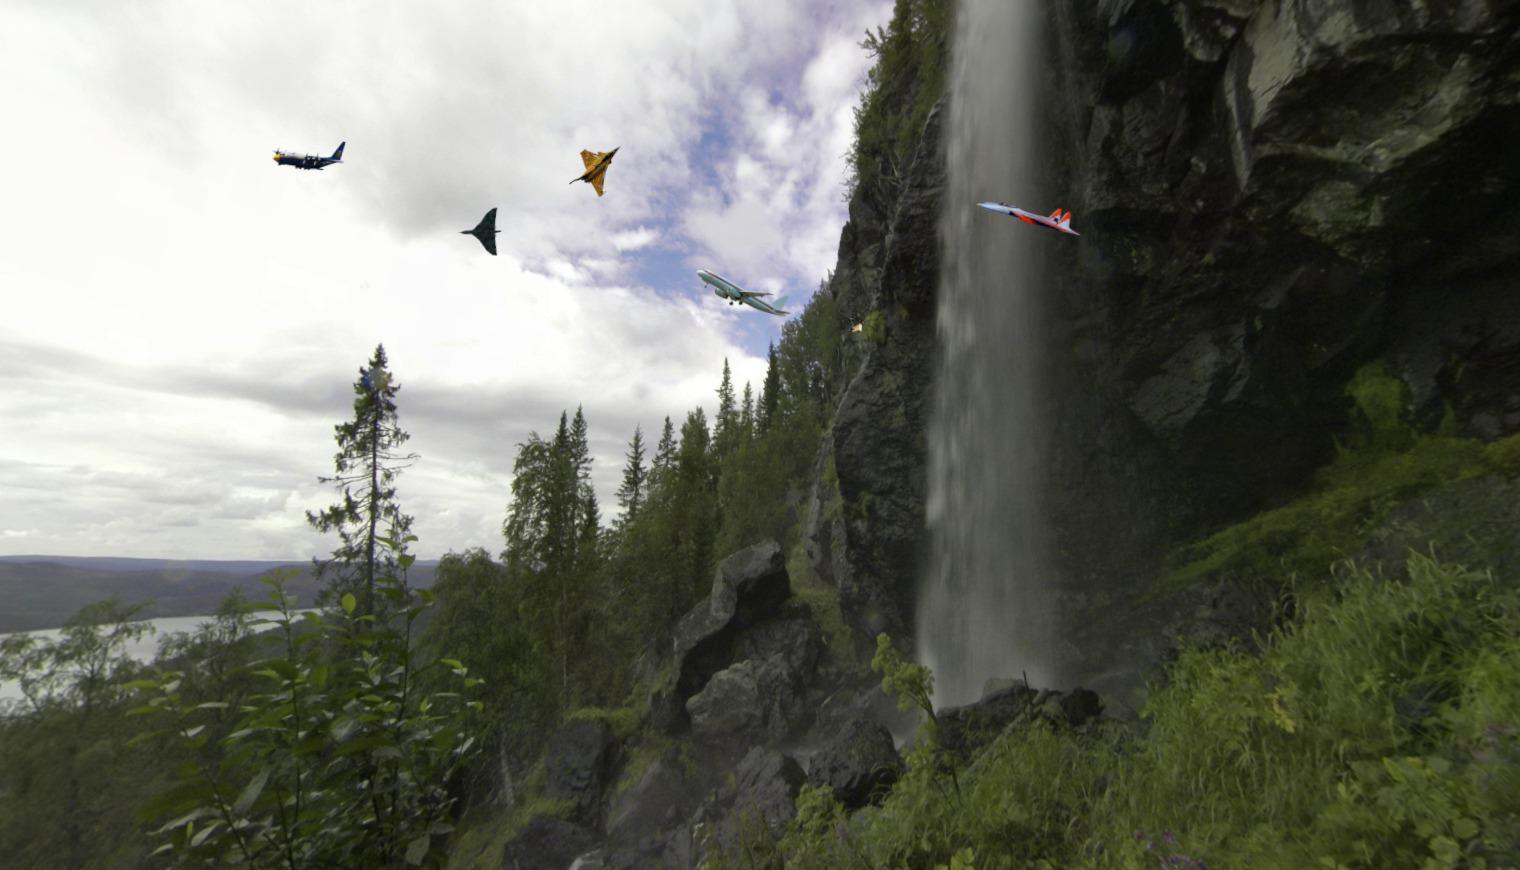

In [14]:
model_path = "local/custom_owl_vit"
detector = pipeline(model=model_path, task="zero-shot-object-detection")

image = vlm_imgs["train"][5]["image"]

predictions = detector(
    image,
    candidate_labels=['yellow fighter plane'],
    threshold=1e-2,
    top_k=8
)
print(predictions)

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymax), f"{label}: {round(score,2)}", fill="black")

image